# Load packages

In [4]:
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Load data

In [5]:
os.getcwd()

csv_path = os.path.join('..', 'inflation-forecasting', 'raw_data')

df = pd.read_csv(os.path.join(csv_path,'data_final.csv'), index_col=0)

# Select data for the US

In [6]:
df_us = df[df['country_id'] == "USA"]

In [7]:
ccpi = pd.DataFrame(df_us['ccpi'])

In [8]:
ccpi = ccpi.to_numpy()

# Load the model for the US

In [9]:
model = load_model("model_usa.h5")
model.summary()

2023-03-11 19:36:02.217944: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-11 19:36:02.218008: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-11 19:36:02.218042: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (AlessandroLaptop): /proc/driver/nvidia/version does not exist
2023-03-11 19:36:02.219391: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                16896     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


# Preprocess the data

In [13]:
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(ccpi.reshape(-1,1))

# Split X and Y into sequences

In [14]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Define steps, features and split data

In [15]:
n_steps_in = 12

n_features = 1

data = dataset[0:]

X, Y = split_sequence(data, n_steps_in)

# Predict and inverse-transform the data

In [16]:
forecast = model.predict(X)

Y_hat = scaler.inverse_transform(forecast)

Y_actual = scaler.inverse_transform(Y)

24/24 [==============================] - 0s 3ms/step


# Plot the data

In [17]:
data1 = pd.DataFrame(forecast)
data2 = pd.DataFrame(Y)

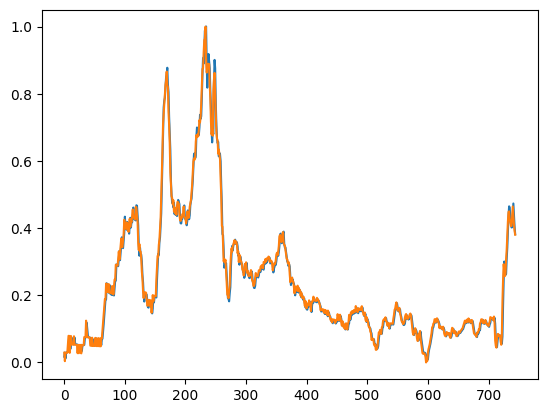

In [18]:
plt.plot(data1)
plt.plot(data2);

# Define the forecasting function

In [19]:
def future_forecasting(dataset, model, mb=12, mf=12):
    '''
    Returns the future forecasting of the model. Please select the dataset and model you want to use.
    for mb, select the number of months you want to look back to make a prediction. 
    for mf, select the number of months you want the prediction to look forward.
    '''
    results = []
    x_input = dataset[-mb:].reshape(1, mb, 1)
    for num in range(mf):
        forecast = model.predict(x_input)
        results.append(forecast[0][0])
        x_input = np.roll(x_input, -1, axis=1)
        x_input[0][-1] = forecast
    results = scaler.inverse_transform(np.array(results).reshape(-1, 1)) # reshape dataset to 2D array
    results = np.array(results).reshape(-1, 1) 
    return results

# Make the forecast for future months (mf)

In [20]:
ccpi = ccpi.to_numpy()
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(ccpi.reshape(-1,1))

inf_for_us = future_forecasting(dataset = dataset, 
                                model = model, 
                                mb = 12, 
                                mf = 12)

1/1 [==============================] - 0s 15ms/step


# Plot of the forecast

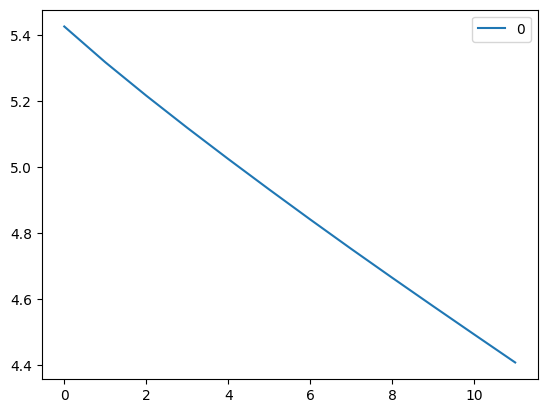

In [22]:
pd.DataFrame(inf_for).plot();